# VQ-VAE in PyTorch

## Import Libraries

In [268]:
from __future__ import print_function
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from scipy.signal import savgol_filter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

## Set Device

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Retrieve Data

Download Celeba Dataset (images and labels)

In [56]:
if not os.path.exists("ms-celeb-images-cropped-aligned.zip"):
    !wget https://maxinai-public-project-images.s3.amazonaws.com/ms-celeb-images-cropped-aligned.zip

In [63]:
if not os.path.exists("list_attr_celeba.csv"):
    !wget https://maxinai-public-project-images.s3.amazonaws.com/list_attr_celeba.csv

Unzip and prepare data

In [58]:
!unzip ms-celeb-images-cropped-aligned.zip > /dev/null

In [60]:
!mv data/ms-celeb-images-cropped-aligned/ data/celeba/

In [64]:
!mv list_attr_celeba.csv data/

## Install TensorBoard

In [107]:
# Run this script if tensorboard fails to run because of duplicate tensorboard libraries
# !pip uninstall tb-nightly tensorboard tensorflow tensorflow-estimator tensorflow-estimator-2.0-preview tf-nightly-2.0-preview -y

In [108]:
# Install working version of tensorflow with tensorboard after removing all tensorboard libraries (in previous cell)
# !pip install tensorflow
# !pip install tensorboard

In [109]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

## Create Dataset

In [77]:
import os
import PIL
from typing import List
from sklearn.model_selection import train_test_split

In [85]:
# defining denormalizer for normalized images.
class DeNormalize:
    
    def __init__(self, mean, std):
        
        self.mean = mean
        self.std = std

    def __call__(self, x, inplace=False):
        
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        tensor = x if inplace else x.clone() 
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        
        return tensor
   

In [81]:
class CelebFaceDataset(torch.utils.data.dataset.Dataset):
    
    def __init__(self, root_dir: str, image_ids: List[str]):
        
        self.root_dir = root_dir
        self.image_ids = image_ids
        
        self.transforms = transforms.Compose([
                                              transforms.Resize((64, 64)),
                                              transforms.ToTensor(),
                                              transforms.Normalize(*IMAGENET_STATS)
                                             ]) 
    def __getitem__(self, idx: int):
        
        im = PIL.Image.open(os.path.join(self.root_dir, self.image_ids[idx]))

        return self.transforms(im)
    
    def __len__(self):
        return len(self.image_ids)

In [140]:
def get_celeba_dls(df: pd.DataFrame, valid_size=0.01, batch_size=128):
    
    train_ids, valid_ids = train_test_split(df.image_id.tolist(), test_size=valid_size)
    
    print('Train size:', len(train_ids), 'Valid Size:', len(valid_ids))
    
    train_ds = CelebFaceDataset(DATA_DIR + '/celeba', train_ids)
    valid_ds = CelebFaceDataset(DATA_DIR + '/celeba', valid_ids)
    
    return (torch.utils.data.DataLoader(train_ds, 
                                        batch_size=batch_size, 
                                        shuffle=True, 
                                        pin_memory=True),
            
            torch.utils.data.DataLoader(valid_ds, 
                                        batch_size=2 * batch_size, 
                                        shuffle=False, 
                                        pin_memory=True))

### Globals

In [151]:
IMAGENET_STATS = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# IMAGENET_STATS = [0.5]*3, [0.5]*3
DATASET_VARIANCE = 0.06158011545822623
DATA_DIR = 'data'
DATA_BATCH_SIZE = 64

### Read dataset Attributes File 

In [128]:
attr_df = pd.read_csv(DATA_DIR + '/list_attr_celeba.csv')

In [129]:
attr_df.head(2)

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1


### Create Denormalizer Object
Will be used for visualizations 

In [152]:
denorm = DeNormalize(*IMAGENET_STATS)

### Get Train/Test Dataloaders

In [153]:
train_dl, valid_dl = get_celeba_dls(attr_df, batch_size=DATA_BATCH_SIZE)

Train size: 194727 Valid Size: 1967


### Show samples from Training Data

In [214]:
def show(img, **kwargs):
    np_img = img.permute(1,2,0).numpy()
    plt.figure(**kwargs)
    fig = plt.imshow(np_img)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [215]:
def show_batch(batch, **kwargs):
    denorm_batch = torch.stack([denorm(sample_batch[i]) for i in range(sample_batch.shape[0])])
    batch_grid = make_grid(denorm_batch)
    show(batch_grid, **kwargs)

In [163]:
sample_batch = next(iter(train_dl))

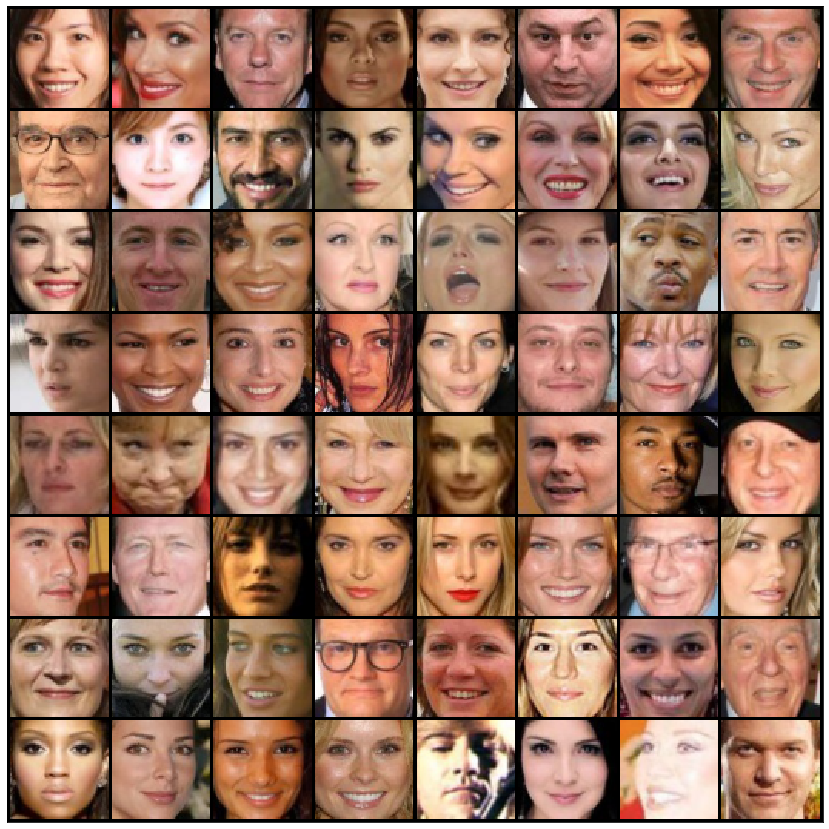

In [217]:
show_batch(sample_batch, **{"figsize":(15, 15)})

## Vector Quantizer Layer

This layer takes a tensor to be quantized. The channel dimension will be used as the space in which to quantize. All other dimensions will be flattened and will be seen as different examples to quantize.

The output tensor will have the same shape as the input.

As an example for a `BCHW` tensor of shape `[16, 64, 32, 32]`, we will first convert it to an `BHWC` tensor of shape `[16, 32, 32, 64]` and then reshape it into `[16384, 64]` and all `16384` vectors of size `64`  will be quantized independently. In otherwords, the channels are used as the space in which to quantize. All other dimensions will be flattened and be seen as different examples to quantize, `16384` in this case.

In [218]:
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost):
        super(VectorQuantizer, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.uniform_(-1/self._num_embeddings, 1/self._num_embeddings)
        self._commitment_cost = commitment_cost

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        q_latent_loss = F.mse_loss(quantized, inputs.detach())
        loss = q_latent_loss + self._commitment_cost * e_latent_loss
        
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

We will also implement a slightly modified version  which will use exponential moving averages to update the embedding vectors instead of an auxillary loss. This has the advantage that the embedding updates are independent of the choice of optimizer for the encoder, decoder and other parts of the architecture. For most experiments the EMA version trains faster than the non-EMA version.

In [219]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings

## Encoder & Decoder Architecture

The encoder and decoder architecture is based on a ResNet and is implemented below:

In [236]:
def init_weights(m: nn.Module):

    for m in m.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight, a=RELU_NEG_SLOPE, nonlinearity='leaky_relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            nn.init.constant_(m.bias, 0)

In [240]:
def deconv_bn_relu(nf: int, of: int, ks: int, stride: int = 1, opad: int = 0, use_bn: bool = True):
    
    deconv = nn.ConvTranspose2d(in_channels=nf, 
                                out_channels=of, 
                                kernel_size=ks, 
                                stride=stride, 
                                padding=ks // 2,
                                output_padding=opad,
                                bias=False)
    
    bn = nn.BatchNorm2d(of)
    
    act = nn.LeakyReLU(RELU_NEG_SLOPE, inplace=True)
    
    return nn.Sequential(deconv, bn, act) if use_bn else nn.Sequential(deconv, act)

In [241]:
class Dec(nn.Module):
    
    def __init__(self, nf: int, in_channels: int = 3):
        
        super().__init__()
                
        deconv1 = deconv_bn_relu(nf,      nf //   2, ks=3, stride=2, opad=1)
        deconv2 = deconv_bn_relu(nf // 2, nf //   4, ks=3, stride=2, opad=1)
        deconv3 = deconv_bn_relu(nf // 4, nf //   8, ks=3, stride=2, opad=1)
        deconv4 = deconv_bn_relu(nf // 8, nf //  16, ks=3, stride=2, opad=1)
        deconv5 = deconv_bn_relu(nf // 16, nf // 32, ks=3, stride=2, opad=1)
        deconv6 = deconv_bn_relu(nf // 32, in_channels, ks=3, use_bn=False)

        self.decoder = nn.Sequential(deconv1, deconv2, deconv3, deconv4, deconv5, deconv6)
        
        init_weights(self)
        
    def forward(self, x):
        return torch.tanh(self.decoder(x))

## Train

We use the hyperparameters from the author's code:

In [242]:
batch_size = 256
num_training_updates = 15000

num_hiddens = 512

embedding_dim = 64

num_embeddings = 512

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

RELU_NEG_SLOPE = 0.2

In [274]:
class Model(nn.Module):
    def __init__(self, num_hiddens, num_embeddings, embedding_dim, commitment_cost, decay=0):
        super(Model, self).__init__()
        
        self._encoder = nn.Sequential(*list(torchvision.models.resnet18(pretrained=True).children())[:-2])
        
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
            
        self._decoder = Dec(embedding_dim)

    def forward(self, x):
        z = self._encoder(x)
        z = self._pre_vq_conv(z)
        loss, quantized, perplexity, _ = self._vq_vae(z)
        x_recon = self._decoder(quantized)

        return loss, x_recon, perplexity

In [275]:
enc_old(sample_batch).shape

torch.Size([64, 128, 16, 16])

In [276]:
enc(sample_batch).shape

torch.Size([64, 512, 2, 2])

In [277]:
model = Model(num_hiddens, num_embeddings, embedding_dim, 
              commitment_cost, decay).to(device)

In [278]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [279]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in range(num_training_updates):
    data = next(iter(train_dl))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / dataset_variance
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

100 iterations
recon_error: 17.374
perplexity: 2.387

200 iterations
recon_error: 13.465
perplexity: 2.639

300 iterations
recon_error: 11.815
perplexity: 3.611

400 iterations
recon_error: 11.356
perplexity: 3.491

500 iterations
recon_error: 10.973
perplexity: 3.942

600 iterations
recon_error: 10.306
perplexity: 5.669

700 iterations
recon_error: 9.288
perplexity: 15.093

800 iterations
recon_error: 8.524
perplexity: 25.280

900 iterations
recon_error: 7.914
perplexity: 32.276

1000 iterations
recon_error: 7.558
perplexity: 39.188

1100 iterations
recon_error: 7.179
perplexity: 42.378

1200 iterations
recon_error: 6.974
perplexity: 44.814

1300 iterations
recon_error: 6.798
perplexity: 46.187

1400 iterations
recon_error: 6.716
perplexity: 47.303

1500 iterations
recon_error: 6.601
perplexity: 48.809

1600 iterations
recon_error: 6.547
perplexity: 50.048

1700 iterations
recon_error: 6.494
perplexity: 51.400

1800 iterations
recon_error: 6.459
perplexity: 53.344

1900 iterations
rec

KeyboardInterrupt: 

## Plot Loss

In [280]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

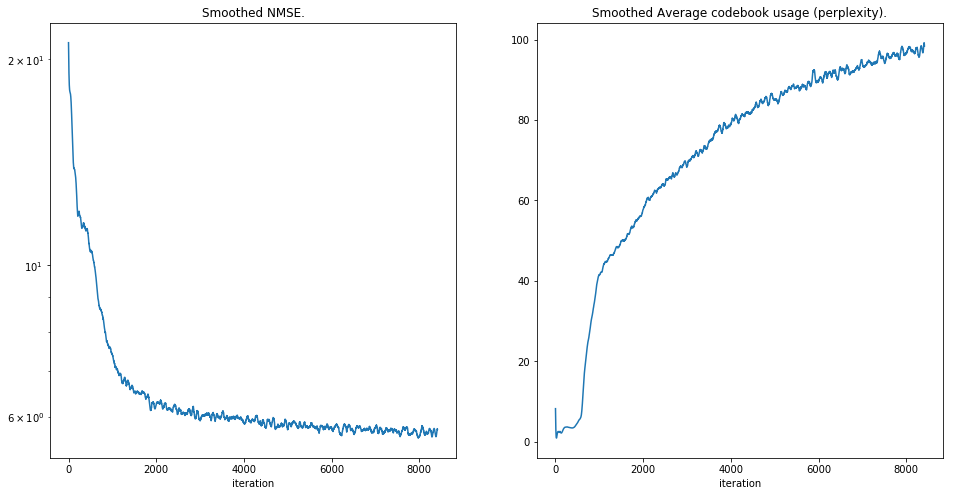

In [281]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

## View Reconstructions

In [282]:
model.eval()

valid_originals = next(iter(valid_dl))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [283]:
train_originals = next(iter(train_dl))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

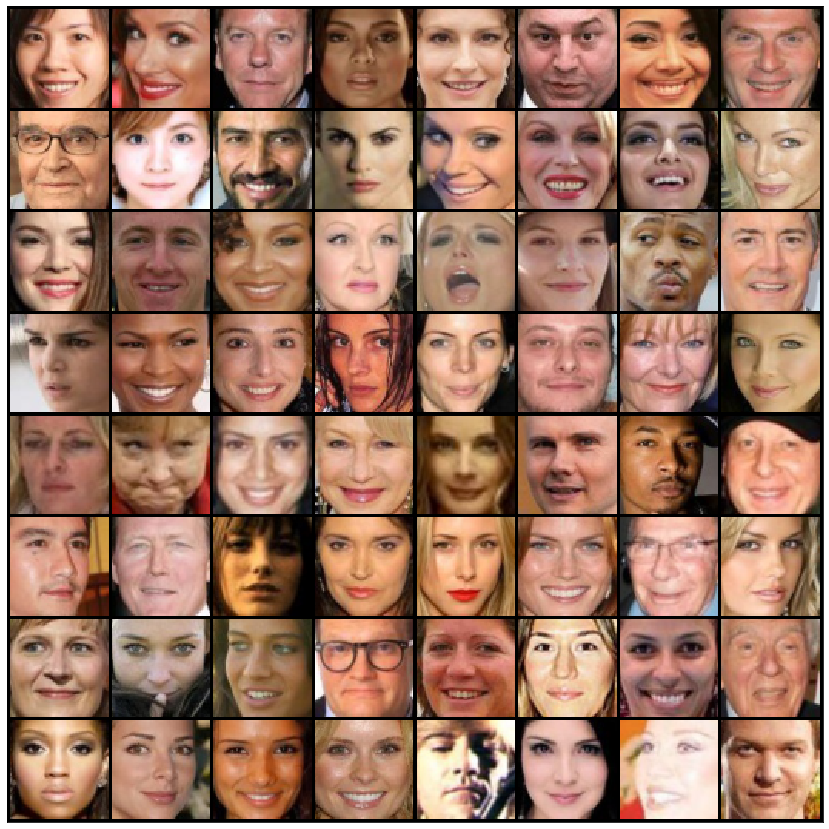

In [285]:
show_batch(valid_reconstructions, **dict(figsize=(15,15)))

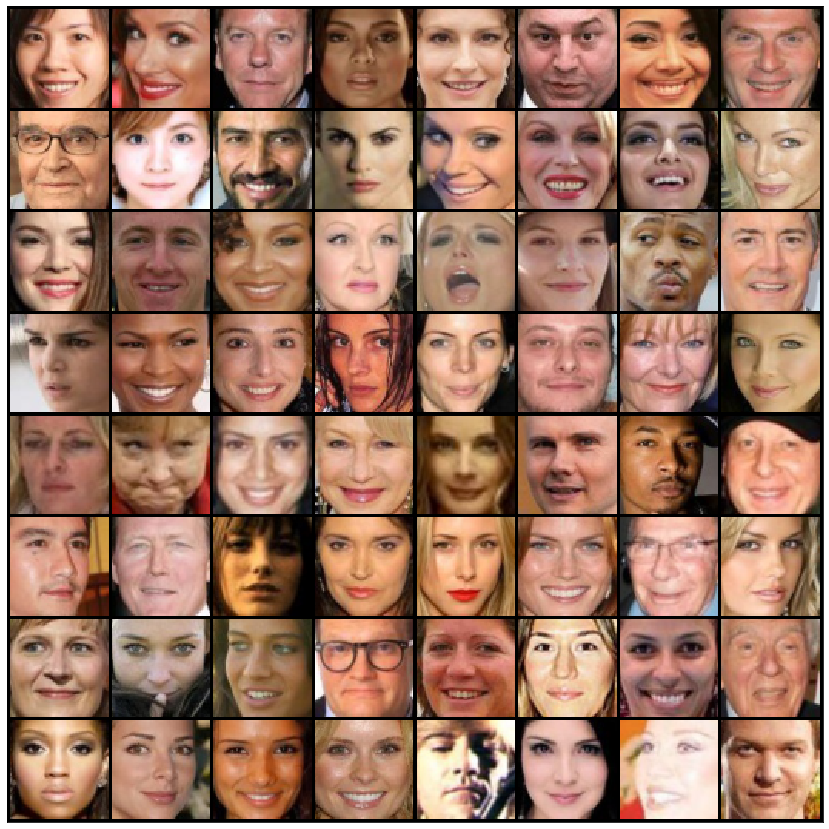

In [286]:
show_batch(valid_originals, **dict(figsize=(15,15)))

## View Embedding

In [287]:
quantized_vectors = model._vq_vae._embedding.weight.data.cpu()

In [288]:
from torch.utils.tensorboard import SummaryWriter

In [289]:
# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

writer.add_embedding(quantized_vectors)
writer.close()

In [290]:
%tensorboard --host=0.0.0.0 --port 8988 --logdir=runs

Reusing TensorBoard on port 8988 (pid 16294), started 2:30:25 ago. (Use '!kill 16294' to kill it.)